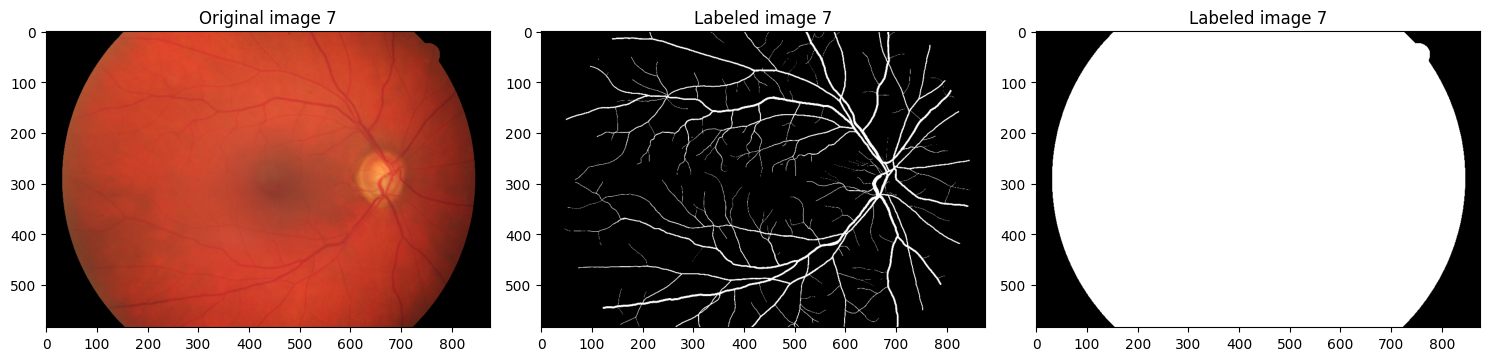

In [2]:
import cv2
import matplotlib.pyplot as plt
import glob
import numpy as np
from skimage.filters import frangi
from sklearn.metrics import confusion_matrix

# Define the new size for the images and img_index
img_index = 7
new_width = int(3504 * 0.25)
new_height = int(2336 * 0.25)

# Read, resize, and normalize the mask images
image_mask_list = [cv2.resize(cv2.imread(filename, 0), (new_width, new_height)) // 255
                   for filename in sorted(glob.glob('mask/*.tif'))]

# Read, resize the original images, and apply the corresponding mask
image_list = [cv2.resize(cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB), (new_width, new_height)) *
              np.dstack([mask, mask, mask])
              for filename, mask in zip(sorted(glob.glob('images/*.jpg')), image_mask_list)]

# Read and resize the labeled images
image_labeled_list = [cv2.resize(cv2.imread(filename, 1), (new_width, new_height)) 
                      for filename in sorted(glob.glob('manual1/*.tif'))]


fig = plt.figure(figsize=(15, 8))

ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title("Original image " + str(img_index))
ax1.imshow(image_list[img_index])
# ax1.axis('off')

ax2 = fig.add_subplot(1, 3, 2)
ax2.set_title("Labeled image " + str(img_index))
ax2.imshow(image_labeled_list[img_index], cmap='gray')
# ax2.axis('off')

ax3 = fig.add_subplot(1, 3, 3)
ax3.set_title("Labeled image " + str(img_index))
ax3.imshow(image_mask_list[img_index], cmap='gray')
# ax3.axis('off')

plt.tight_layout()
plt.show()

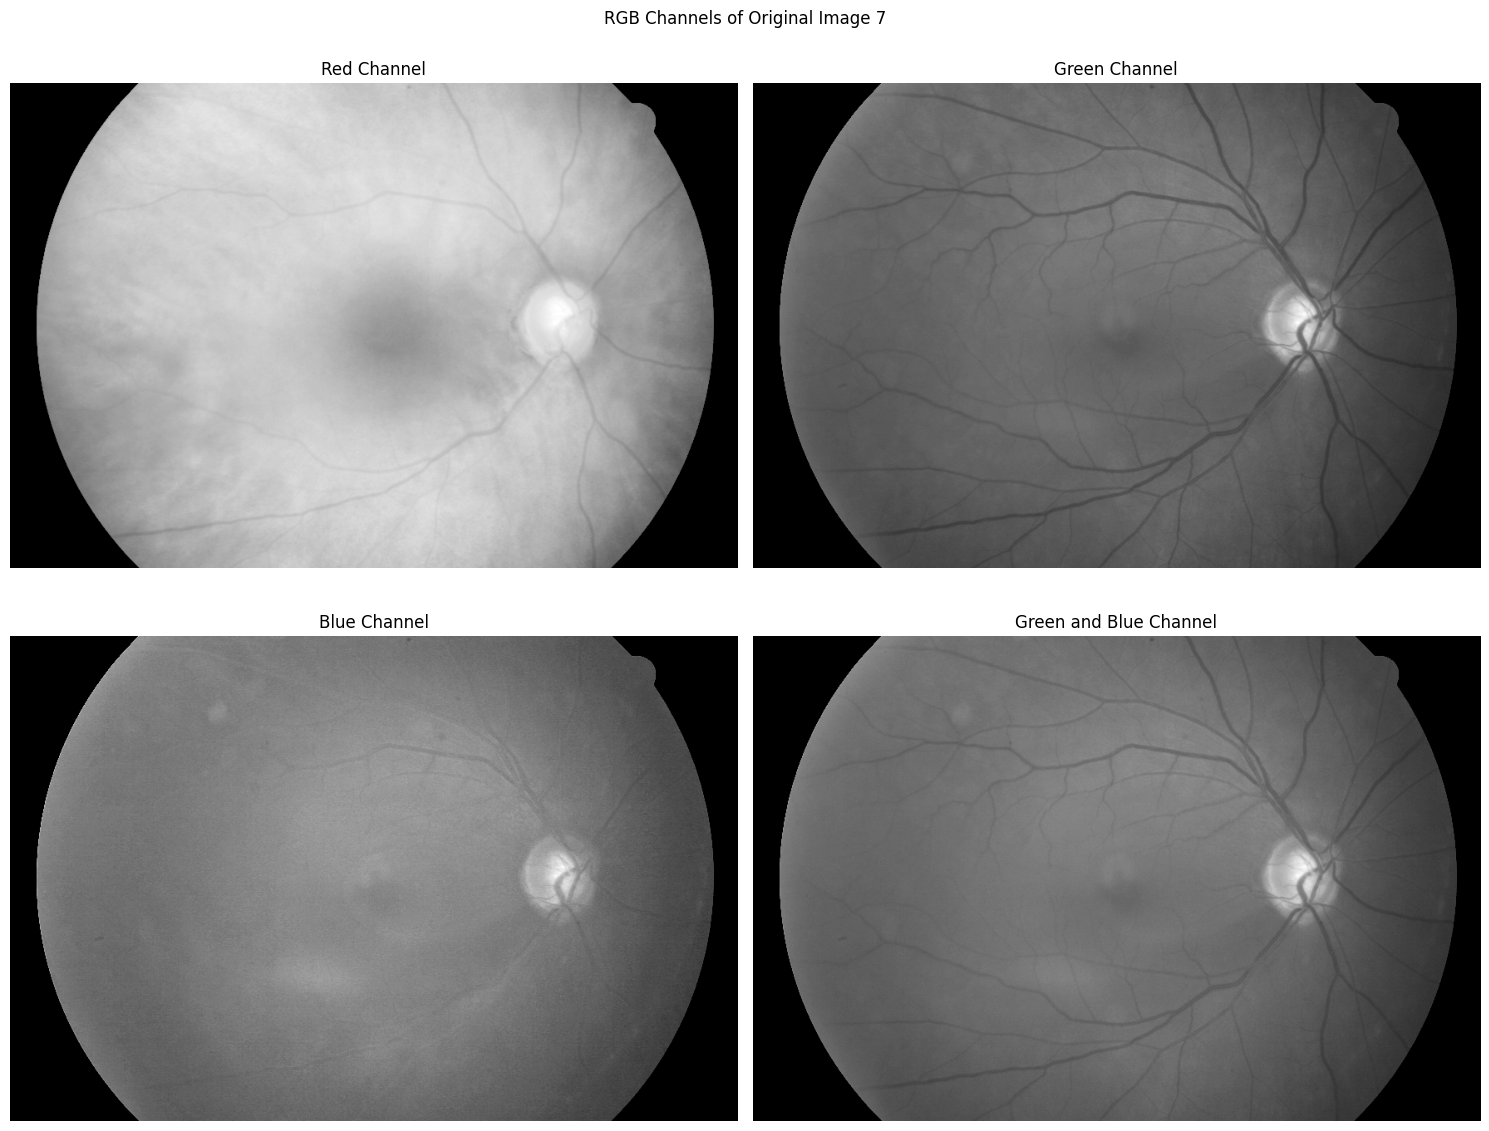

In [3]:
# Now, plot the three separate color channels
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle("RGB Channels of Original Image " + str(img_index))

# Extracting the Red, Green, and Blue channels
red_channel = image_list[img_index][:, :, 0]
green_channel = image_list[img_index][:, :, 1]
blue_channel = image_list[img_index][:, :, 2]
green_blue_channel = (green_channel / 2 + blue_channel / 2).astype('uint8')
# Plot each channel
axs[0, 0].imshow(red_channel, cmap='gray')
axs[0, 0].set_title("Red Channel")
axs[0, 0].axis('off')

axs[0, 1].imshow(green_channel, cmap='gray')
axs[0, 1].set_title("Green Channel")
axs[0, 1].axis('off')

axs[1, 0].imshow(blue_channel, cmap='gray')
axs[1, 0].set_title("Blue Channel")
axs[1, 0].axis('off')

axs[1, 1].imshow(green_blue_channel, cmap='gray')
axs[1, 1].set_title("Green and Blue Channel")
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

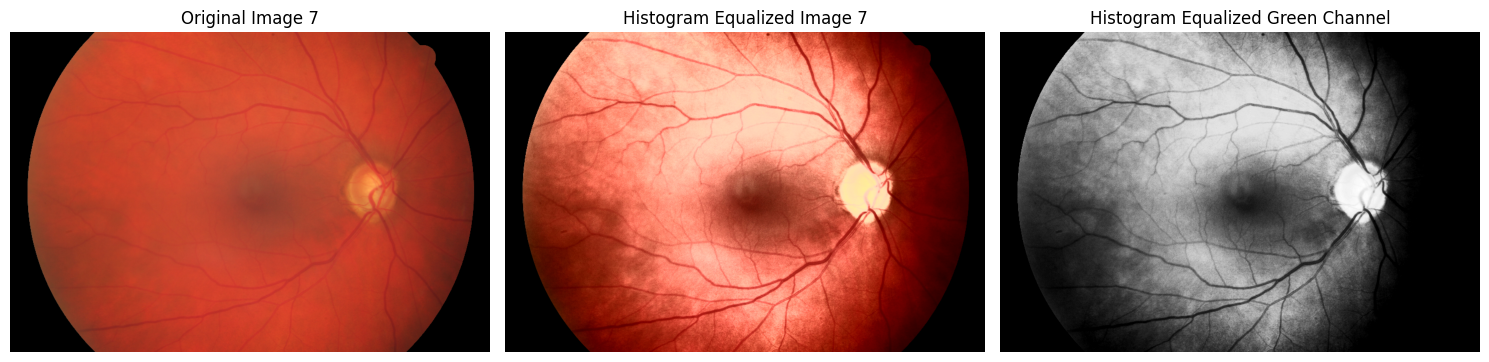

In [4]:
def equalize_histogram_rgb(image):
    # Convert the image from RGB to YCrCb color space
    ycrcb_img = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

    # Equalize the histogram of the Y channel (luminance)
    ycrcb_img[:, :, 0] = cv2.equalizeHist(ycrcb_img[:, :, 0])

    # Convert the image back to RGB color space
    equalized_img = cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2RGB)
    return equalized_img

normalized_image = equalize_histogram_rgb(image_list[img_index])
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Display the original image
axs[0].imshow(image_list[img_index])
axs[0].set_title("Original Image " + str(img_index))
axs[0].axis('off')

# Display the histogram-equalized image
axs[1].imshow(normalized_image)
axs[1].set_title("Histogram Equalized Image " + str(img_index))
axs[1].axis('off')

axs[2].imshow(normalized_image[:,:,1], cmap="gray")
axs[2].set_title("Histogram Equalized Green Channel")
axs[2].axis('off')

plt.tight_layout()
plt.show()

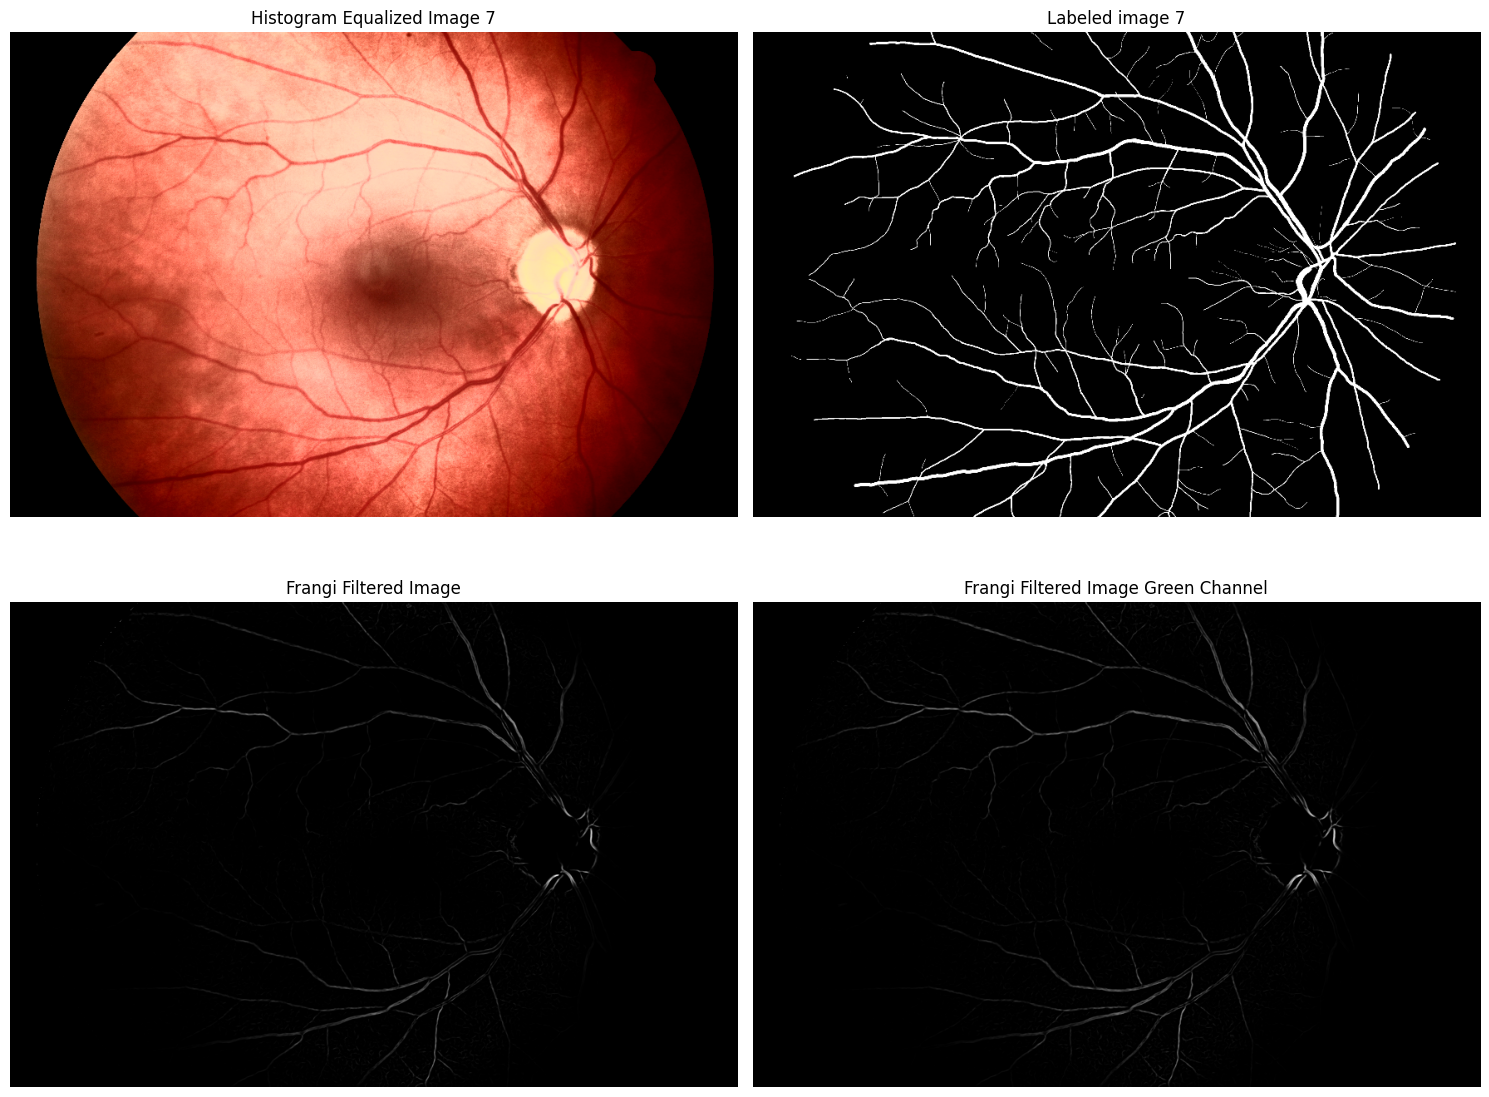

In [5]:
# Define a function to apply Frangi filter to an image
def apply_frangi_filter(image, alpha=0.5, beta=0.5, gamma=None):
    # Convert the image to grayscale if it's not already
    if len(image.shape) == 3:
        image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        image_gray = image
    frangi_image = frangi(image_gray, alpha=alpha, beta=beta, gamma=gamma)
    return frangi_image


# Apply Frangi filter to the selected image
frangi_result = apply_frangi_filter(normalized_image) * image_mask_list[img_index]
frangi_green_channel = apply_frangi_filter(normalized_image[:, :, 1]) * image_mask_list[img_index]

# Plot the original image and the Frangi-filtered result
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Display the original image
axs[0, 0].imshow(normalized_image, cmap='gray' if len(normalized_image.shape) == 2 else None)
axs[0, 0].set_title("Histogram Equalized Image " + str(img_index))
axs[0, 0].axis('off')

# Display the Frangi-filtered image with only green channel
axs[0, 1].imshow(image_labeled_list[img_index], cmap='gray')
axs[0, 1].set_title("Labeled image " + str(img_index))
axs[0, 1].axis('off')


# Display the Frangi-filtered image
axs[1, 0].imshow(frangi_result, cmap='gray')
axs[1, 0].set_title("Frangi Filtered Image")
axs[1, 0].axis('off')

# Display the Frangi-filtered image with only green channel
axs[1, 1].imshow(frangi_green_channel, cmap='gray')
axs[1, 1].set_title("Frangi Filtered Image Green Channel")
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

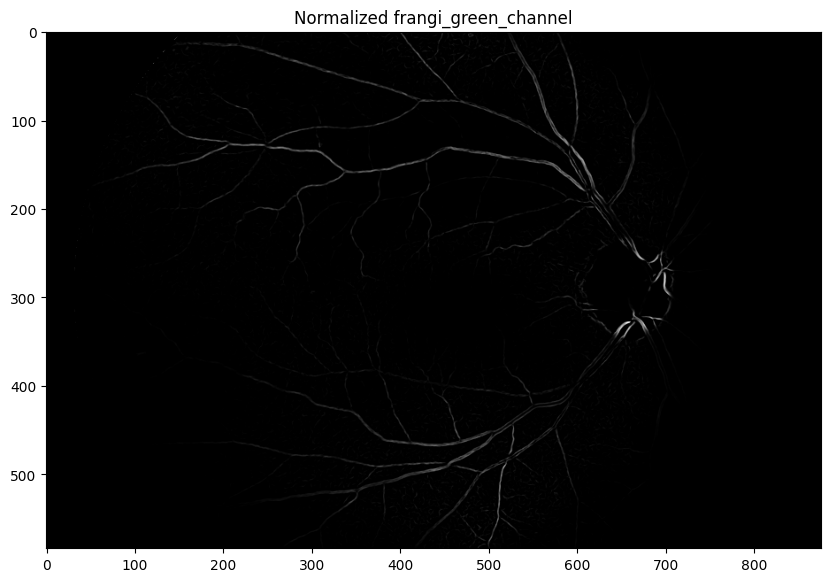

In [6]:
def normalize_image(img):
    img_min = np.min(img)
    img_max = np.max(img)
    if img_max != img_min:
        return (255 * (img - img_min) / (img_max - img_min)).astype(np.uint8)
    else:
        return (np.zeros_like(img)).astype(np.uint8)

frangi_green_channel_uint8 = normalize_image(frangi_green_channel)
fig = plt.figure(figsize=(10, 10))

plt.imshow(frangi_green_channel_uint8, cmap='gray')
plt.title("Normalized frangi_green_channel")
plt.show()

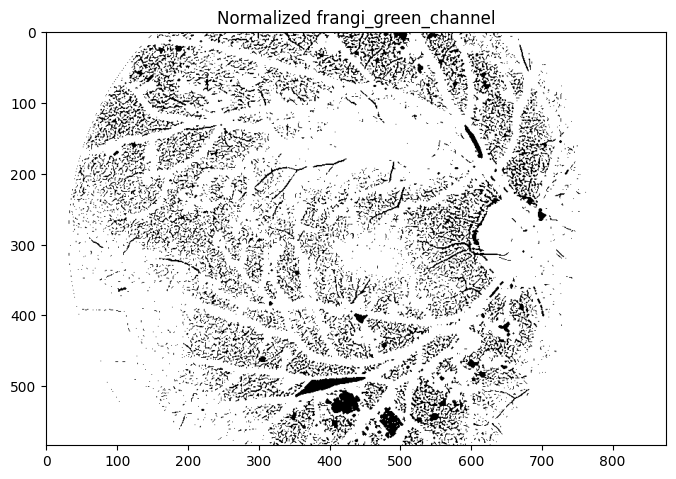

In [7]:
def generate_noise_mask(img, contour_threshold):
    mask = np.ones(img.shape, dtype=np.uint8) * 255
    
    # Find contours and remove small ones from the mask
    contours, _ = cv2.findContours(img.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        if cv2.contourArea(contour) <= contour_threshold:
            cv2.drawContours(mask, [contour], -1, [0], -1)
    return mask
    

# Display the mask
fig = plt.figure(figsize=(8, 8))

nm = generate_noise_mask(frangi_green_channel_uint8, 1000)
plt.imshow(nm, cmap='gray')
plt.title("Normalized frangi_green_channel")
plt.show()

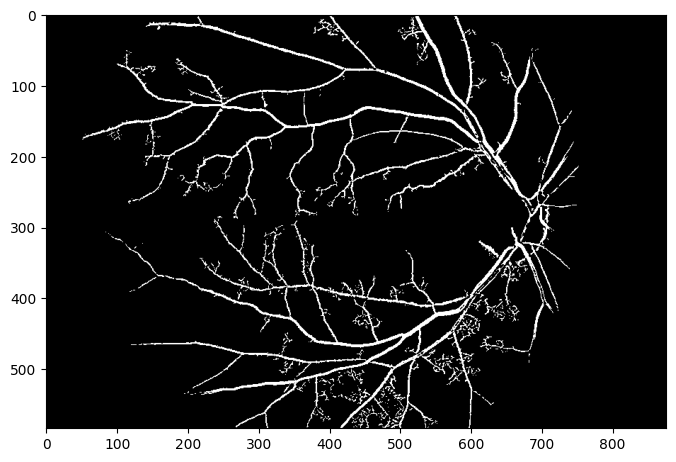

In [8]:
_,im_th = cv2.threshold(frangi_green_channel_uint8,1,255,cv2.THRESH_BINARY)
fig = plt.figure(figsize=(8, 8))
plt.imshow(im_th*nm,cmap='gray')
plt.show()

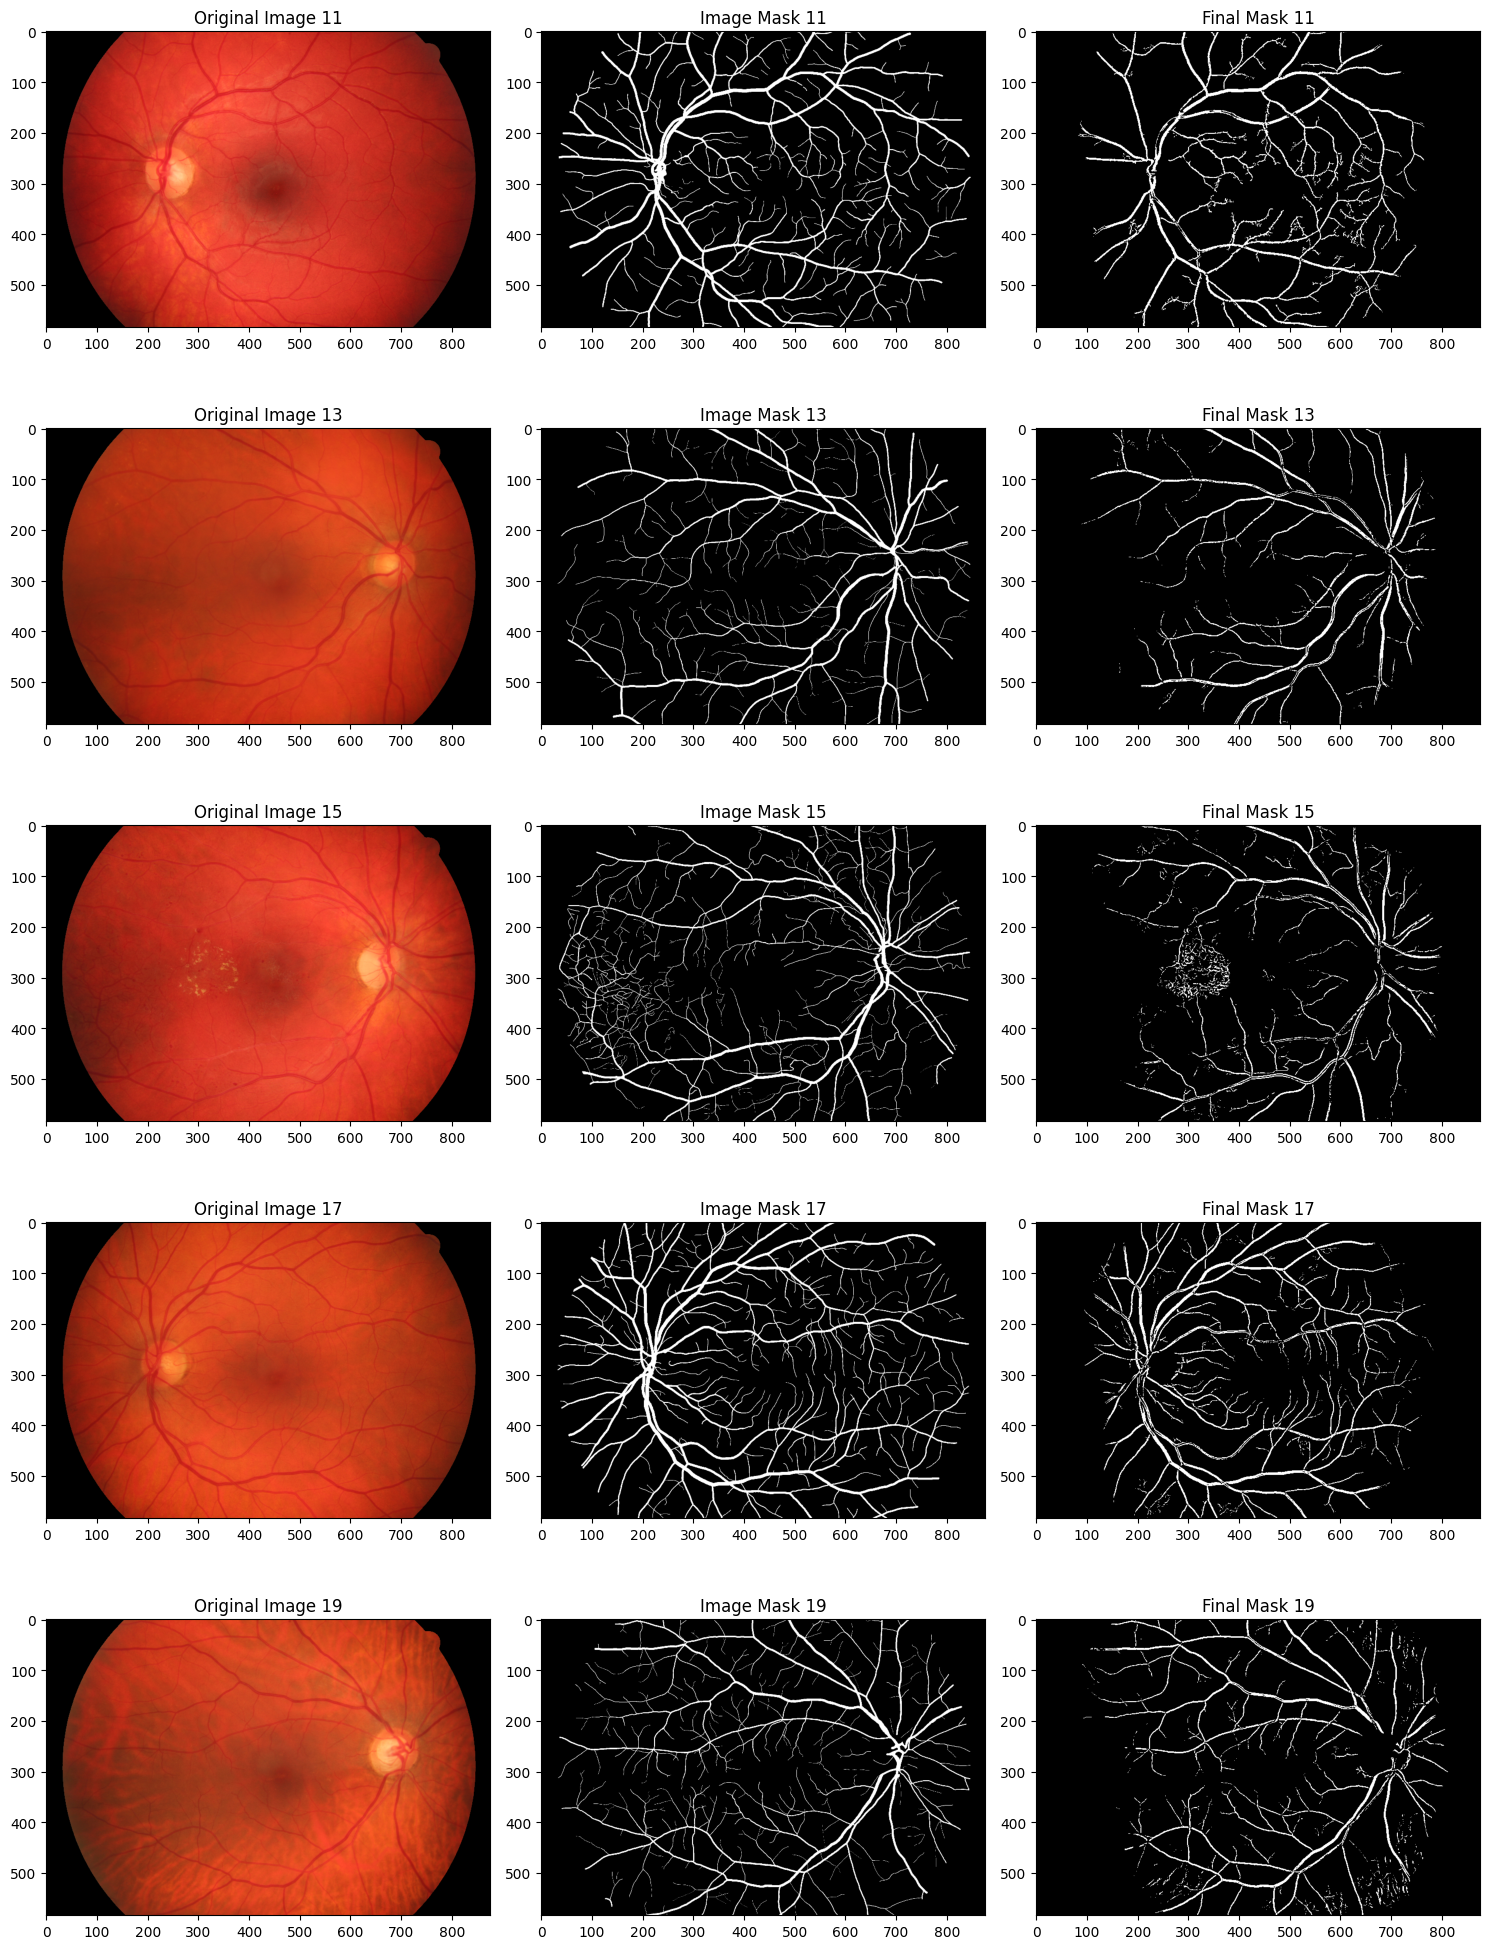

In [9]:
def get_labeled(index, threshold_value, contour_threshold, alpha=0.5, beta=0.5, gamma=None):
    equalized = equalize_histogram_rgb(image_list[index])
    frangi_green = apply_frangi_filter(equalized[:, :, 1], alpha, beta, gamma) * image_mask_list[index]
    normalized = normalize_image(frangi_green)
    noise_mask = generate_noise_mask(normalized, contour_threshold)
    _, threshold = cv2.threshold(normalized,threshold_value,255,cv2.THRESH_BINARY)
    return threshold * noise_mask


# 
# parameters = [[7, 1, 1000, 0.5, 0.28, 20],
#               [12, 10, 100, 0.5, 0.3, 20],
#               [13, 8, 50, 0.5, 0.27, 25],
#               [14, 8, 50, 0.5, 0.27, 25],
#               [16, 8, 50, 0.5, 0.27, 25]]
parameters = [[11, 1, 1000, 0.5, 0.28, 20],
              [13, 8, 50, 0.5, 0.27, 25],
              [15, 10, 100, 0.5, 0.3, 20],
              [17, 8, 50, 0.5, 0.27, 25],
              [19, 8, 50, 0.5, 0.27, 25]]

final_masks = []
for i, params in enumerate(parameters):
    index, threshold_value, contour_threshold, alpha, beta, gamma = params
    mask = get_labeled(index, threshold_value, contour_threshold, alpha, beta, gamma)
    final_masks.append(mask)


fig, axs = plt.subplots(len(parameters), 3, figsize=(15, 4*len(parameters)))
for i, params in enumerate(parameters):
    axs[i, 0].imshow(image_list[params[0]])
    axs[i, 0].set_title('Original Image ' + str(params[0]))
    
    axs[i, 1].imshow(image_labeled_list[params[0]], cmap='gray')
    axs[i, 1].set_title('Image Mask ' + str(params[0]))
    
    axs[i, 2].imshow(final_masks[i], cmap='gray')
    axs[i, 2].set_title('Final Mask ' + str(params[0]))

plt.tight_layout()
plt.show()

In [10]:
def calculate_metrics(true_mask, predicted_mask):
    # Flatten the masks
    true_mask_flat = true_mask.flatten()
    predicted_mask_flat = predicted_mask.flatten() * 255
    
    
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(true_mask_flat, predicted_mask_flat, labels=[0, 255]).ravel()

    # Calculate metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    balanced_accuracy = (sensitivity + specificity) / 2
    
    return accuracy, sensitivity, specificity, balanced_accuracy

predicted_masks = final_masks
true_masks = [image_labeled_list[index] for index in [param[0] for param in parameters]]

for i, pair in enumerate(zip(true_masks, predicted_masks)):
    my_accuracy, my_sensitivity, my_specificity, my_balanced_accuracy = calculate_metrics(pair[0][:, :, 0], pair[1])
    print(f'****** Image {parameters[i][0]} ******')
    print(f'Accuracy: {my_accuracy:.4f}')
    print(f'Sensitivity: {my_sensitivity:.4f}')
    print(f'Specificity: {my_specificity:.4f}')
    print(f'Balanced Accuracy: {my_balanced_accuracy:.4f}')
    print(" ")

****** Image 11 ******
Accuracy: 0.9596
Sensitivity: 0.6267
Specificity: 0.9907
Balanced Accuracy: 0.8087
 
****** Image 13 ******
Accuracy: 0.9714
Sensitivity: 0.5923
Specificity: 0.9942
Balanced Accuracy: 0.7932
 
****** Image 15 ******
Accuracy: 0.9524
Sensitivity: 0.4315
Specificity: 0.9876
Balanced Accuracy: 0.7096
 
****** Image 17 ******
Accuracy: 0.9627
Sensitivity: 0.6336
Specificity: 0.9956
Balanced Accuracy: 0.8146
 
****** Image 19 ******
Accuracy: 0.9727
Sensitivity: 0.6834
Specificity: 0.9895
Balanced Accuracy: 0.8364
 
